# SN Like candidates in the last 4 days
### Ken Smith
Get supernova candidates ingested into Lasair within the last 4 days.  This notebook will use the Lasair client code, except for acquisiton of the user token.

Demonstrates usage of:
* /query/
* /objects/

### Python (3 only) requirements - pip install
lasair, requests

### Grab my Lasair API token
Get your token before you start.  Change the cell below to enter your own credentials, or better still, set the last line of this cell to be your token ID.  You can also collect your token this way

```bash
curl --data "username=tutorial&password=***********" https://lasair-iris.roe.ac.uk/api/auth-token/
```
You should get the following response:
```json
{"token":"acf14c2788ec5d7abb351f06e9ce2624a810b2ab"}
```
We will use this token temporarily, but note that it will be disabled after the workshop!

In [9]:
from astropy.time import Time
import matplotlib.pyplot as plt

from lasair import LasairError, lasair_client as lasair
import requests

# What is my Lasair API Key?
# THIS ACCOUNT IS TEMPORARY AND WILL BE DELETED AFTER THE WORKSHOP

token = "acf14c2788ec5d7abb351f06e9ce2624a810b2ab"

### Make an SQL query
Note that the database is not very old - a few months.  (It's very much a prototype system, which may be destroyed and rebuilt at a moment's notice.)  Hence there will be no data older than 2021 in this system.

In [10]:
selected = """
objects.objectId,
objects.ramean,
objects.decmean,
objects.jdmin - 2400000.5 AS mjdmin,
objects.jdmax - 2400000.5 AS mjdmax,
objects.magrmin,
objects.rmag,
sherlock_classifications.classification,
IF(objects.distpsnr1 < 2 AND objects.sgscore1 > 0.49, "PS1_star", "Not_PS1_star") score
"""

tables = 'objects,sherlock_classifications'

conditions = """
objects.jdmin > JDNOW() - 4.0
AND sherlock_classifications.classification NOT IN ("VS" , "AGN", "CV", "BS")
AND objects.ncand >= 3
AND objects.gmag < 20
AND objects.ncandgp > 1
AND objects.objectId like 'ZTF21%'
ORDER BY score, objectId DESC 
"""

L = lasair(token)
try:
    results = L.query(selected, tables, conditions, limit = 10)
except LasairError as e:
    print(e)


In [11]:
for row in results:
    print(row['objectId'],
          "%.5f" % row['ramean'],
          "%.5f" % row['decmean'],
          "%.5f" % row['mjdmin'],
          "%.5f" % row['mjdmax'],
          "%.2f" % row['magrmin'],
          "%.2f" % row['rmag'],
          row['classification'],
          row['score'])
    

ZTF21aasttsm 113.50309 79.58463 59308.22219 59308.22219 20.26 20.26 UNCLEAR Not_PS1_star
ZTF21aasrcgd 238.34824 44.09844 59307.36574 59309.41019 19.50 19.50 SN Not_PS1_star
ZTF21aaskxwu 285.76094 31.98002 59308.46861 59310.49800 18.44 19.37 SN Not_PS1_star
ZTF21aasfseg 132.55872 37.02699 59308.21492 59310.20014 18.45 18.45 SN Not_PS1_star
ZTF21aasfgxx 89.17573 50.36135 59308.20187 59310.20681 19.51 19.51 SN Not_PS1_star
ZTF21aasdyot 79.81934 44.74189 59308.16333 59310.17861 17.76 17.87 SN Not_PS1_star
ZTF21aascgal 239.57931 -1.89734 59307.44176 59309.46223 19.61 19.61 SN Not_PS1_star
ZTF21aasbumk 238.40086 14.49401 59307.41271 59307.41271 19.64 19.64 SN Not_PS1_star
ZTF21aasbjgq 212.39735 11.15310 59307.37888 59309.39498 19.08 19.08 SN Not_PS1_star
ZTF21aasbajb 227.88446 61.04322 59307.36858 59307.36858 19.92 19.92 NT Not_PS1_star


### Grab the lightcurves using the objects API

ZTF21aasttsm is not on TNS yet
AT2021iay
ZTF21aaskxwu is not on TNS yet
AT2021ibn
AT2021ids
AT2021iep
AT2021hwi
AT2021hwl
AT2021hwq
AT2021hwt


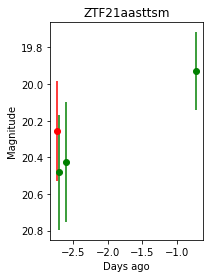

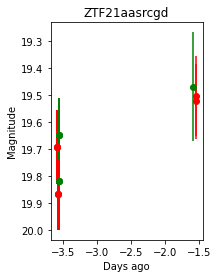

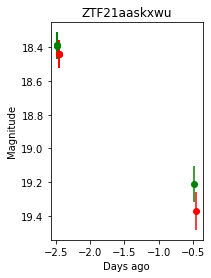

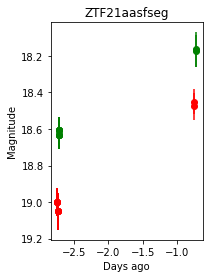

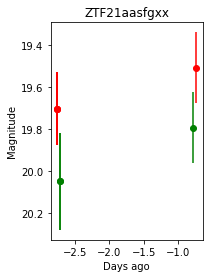

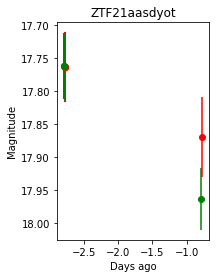

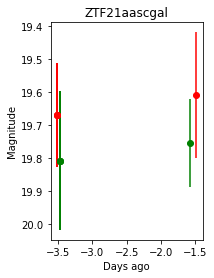

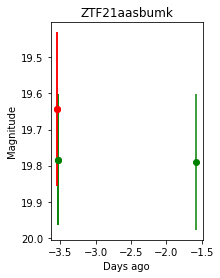

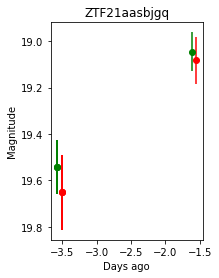

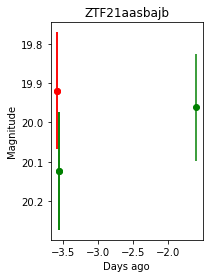

In [12]:
objectList = [row['objectId'] for row in results]
response = L.objects(objectList)

# create an dictionary of lightcurves

lcsDict = {}
for obj in response:    
    lcsDict[obj['objectId']] = {'candidates': obj['candidates']}

cols = {1:'g',2:'r'}

now = Time.now().jd

for obj in response:
        try:
            print ("%s%s" % (obj['TNS']['tns_prefix'], obj['TNS']['tns_name']))
        except KeyError as e:
            print (obj['objectId'], "is not on TNS yet")
        plt.figure()
        plt.subplot(121)
        for i in lcsDict[obj['objectId']]['candidates']:
            if 'isdiffpos' in i:
                if i['isdiffpos']=='t':
                    plt.errorbar(i['jd']-now,i['magpsf'],i['sigmapsf'],fmt='o',color=cols[i['fid']])
        plt.gca().invert_yaxis()
        plt.ylabel('Magnitude')
        plt.xlabel('Days ago')
        plt.title(obj['objectId'])
